In [ ]:
# Imports
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [27]:
# --- Plotting Functions (adapted) ---

# Re-define the plotting functions to accept PyTorch model outputs

# --- Helper Functions (from your provided code) ---
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def plot_confusion_matrix(y_true, y_pred, labels=["Background", "Signal"]):
    """
    Plot a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
    ax.set_title("Normalized Confusion Matrix")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_binned_background_shape(
    probs, # Pass probabilities directly now
    y_true, # Pass true labels
    mass_unscaled, # Pass the unscaled mass
    weight,
    bins=np.linspace(110, 160, 80),
    score_bins=[(0.00, 0.34), (0.34, 0.68), (0.68, 0.9), (0.9, 1.0)],
    colors=["blue", "orange", "green", "red"],
    higgs_mass=125
):
    """
    Plot binned dimuon mass distribution for background events,
    separated by classifier score bins, with exponential background fit.
    Now takes probabilities and unscaled mass directly.
    """

    # Ensure proper array types
    y_true = np.asarray(y_true)
    weight = np.asarray(weight)
    probs = np.asarray(probs)
    mass_unscaled = np.asarray(mass_unscaled)


    # Select background events
    mask_bkg = y_true == 0
    scores = probs[mask_bkg]
    masses = mass_unscaled[mask_bkg]
    weights_bkg = weight[mask_bkg]

    # Setup bins and labels
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    labels = [f"{low:.2f} ≤ Score < {high:.2f}" for (low, high) in score_bins]

    plt.figure(figsize=(9, 6))

    # Plot histograms by classifier score
    for (low, high), color, label in zip(score_bins, colors, labels):
        mask = (scores >= low) & (scores < high)
        hist, _ = np.histogram(masses[mask], bins=bins, weights=weights_bkg[mask], density=True)
        plt.step(bin_centers, hist, where="mid", color=color, label=label)

    # Full background shape and fit
    hist_all, _ = np.histogram(masses, bins=bins, weights=weights_bkg, density=True)
    try:
        # Filter out zeros from hist_all for fitting if necessary
        valid_indices = hist_all > 0
        popt, _ = curve_fit(exp_decay, bin_centers[valid_indices], hist_all[valid_indices], p0=(1, 0.1, 0))
        smoothed = exp_decay(bin_centers, *popt)
        plt.plot(bin_centers, smoothed, 'k--', label="Fitted Background Shape")
    except RuntimeError:
        print("⚠️ Background fit failed. Skipping fit curve.")
    except ValueError as e:
         print(f"⚠️ Background fit failed due to ValueError: {e}. Skipping fit curve.")


    # Higgs mass line
    plt.axvline(higgs_mass, color="gray", linestyle=":", label="Higgs Mass")

    # Final styling
    plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
    plt.ylabel("Fraction of events")
    plt.title("Background Shape by Classifier Score")
    plt.legend(title="Score Bins")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
def load_data(file_path, columns, tree_name="tree_Hmumu"):
    """
    Load data from a ROOT file using uproot.
    """
    try:
        tree = uproot.open(file_path)[tree_name]
        df = tree.arrays(columns, library="pd")
        # Consider if sampling is always desired or should be a parameter
        df_sampled = df.sample(frac=0.05, random_state=42)  # Added random_state for reproducibility
        # For now, using the full dataset as frac=0.1 might be too small for robust training
        return df_sampled
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        print("Please ensure the ROOT files are in the correct path and uproot is installed.")
        # Return empty DataFrame or raise to stop execution
        return pd.DataFrame()


def prepare_data(background_df, signal_df, mass_column="Muons_Minv_MuMu_Fsr", shuffle=True):
    """
    Combine background and signal datasets, shuffle, and split into features, labels, weights, and mass.
    """
    if background_df.empty or signal_df.empty:
        print("One or both dataframes are empty. Cannot prepare data.")
        # Return empty tuples to signal failure
        return pd.DataFrame(), pd.Series(dtype="float64"), pd.Series(dtype="float64"), np.array([])

    df = pd.concat([background_df, signal_df], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    x = df.drop(["Binary_Target", "weight", mass_column], axis=1)
    y = df["Binary_Target"]
    mass = df[mass_column]
    weight = df["weight"].to_numpy()

    y = y.to_numpy()
    mass = mass.to_numpy()

    return x, y, mass, weight


def split_and_scale(X, y, mass, weight, test_size=0.2):
    """
    Split the dataset and apply standard scaling to features and mass separately.
    """
    if X.empty:
        print("Input feature DataFrame X is empty in split_and_scale. Cannot proceed.")
        # Return dummy values or raise an error
        return (None,) * 10 + ([],)  # Match number of return values

    X_train, X_test, y_train, y_test, mass_train, mass_test, weight_train, weight_test = (
        train_test_split(X, y, mass, weight, test_size=test_size, random_state=42, stratify=y)
    )

    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    mass_scaler = StandardScaler()
    mass_train_scaled = mass_scaler.fit_transform(mass_train.reshape(-1, 1)).flatten()
    mass_test_scaled = mass_scaler.transform(mass_test.reshape(-1, 1)).flatten()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    mass_train_tensor = torch.tensor(mass_train_scaled, dtype=torch.float32).unsqueeze(1)
    mass_test_tensor = torch.tensor(mass_test_scaled, dtype=torch.float32).unsqueeze(1)
    weight_train_tensor = torch.tensor(weight_train, dtype=torch.float32)
    weight_test_tensor = torch.tensor(weight_test, dtype=torch.float32)

    return (
        X_train_tensor,
        X_test_tensor,
        y_train_tensor,
        y_test_tensor,
        mass_train_tensor,
        mass_test_tensor,
        weight_train_tensor,
        weight_test_tensor,
        feature_scaler,
        mass_scaler,
        X.columns.tolist(),
    )  # Return feature names


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim_clf, hidden_dim_clf_2, output_dim_clf=1, dropout_rate=0.1):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_clf)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim_clf, hidden_dim_clf_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim_clf_2, output_dim_clf)

    def forward(self, x):
        h1_clf = self.relu1(self.fc1(x))
        h1_clf_dropped = self.dropout1(h1_clf)
        h2_clf = self.relu2(self.fc2(h1_clf_dropped))
        h2_clf_dropped = self.dropout2(h2_clf)
        # The adversary will receive h1_clf (the "raw" activated hidden state)
        # The classifier's path to output uses dropout on this hidden state
        logits = self.fc3(h2_clf_dropped)
        return logits, h2_clf_dropped  # Return hidden layer for adversary


class Adversary(nn.Module):
    def __init__(self, input_dim_adv, hidden_dim_adv, output_dim_adv=1):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim_adv, hidden_dim_adv)
        self.relu = nn.ReLU()
        # Optional: add dropout to adversary too if it's too strong or overfits
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim_adv, output_dim_adv)

    def forward(self, h_from_classifier):
        h_adv = self.relu(self.fc1(h_from_classifier))
        h_adv = self.dropout(h_adv)
        mass_prediction = self.fc2(h_adv)
        return mass_prediction


# --- Training Function ---
def train_adversarial_debiasing(
    classifier,
    adversary,
    train_loader,
    optimizer_clf,
    optimizer_adv,
    criterion_clf,
    criterion_adv,
    num_epochs,
    adversary_loss_weight,
    device,
    debias=True,
):
    print(f"Starting training for {num_epochs} epochs...")
    print(
        f"Debiasing active: {debias}, Adversary loss weight: {adversary_loss_weight if debias else 'N/A'}"
    )

    for epoch in range(num_epochs):
        classifier.train()
        if debias:
            adversary.train()

        total_clf_loss_epoch = 0
        total_adv_loss_epoch = 0
        total_clf_task_loss_epoch = 0  # For monitoring main task performance

        for batch_idx, (features, labels, mass_targets) in enumerate(train_loader):
            features, labels, mass_targets = (
                features.to(device),
                labels.to(device),
                mass_targets.to(device),
            )

            # --- Step 1: Train Adversary (if debiasing is active) ---
            if debias:
                optimizer_adv.zero_grad()
                # Get hidden representation from classifier (don't track gradients for classifier here)
                with torch.no_grad():  # Ensure classifier weights are not updated based on this
                    _, hidden_rep_for_adv = classifier(features)

                # Adversary predicts mass from the detached hidden representation
                mass_pred_by_adv = adversary(
                    hidden_rep_for_adv.detach()
                )  # Detach again just to be sure
                loss_adv = criterion_adv(mass_pred_by_adv, mass_targets)
                loss_adv.backward()
                optimizer_adv.step()
                total_adv_loss_epoch += loss_adv.item()

            # --- Step 2: Train Classifier ---
            optimizer_clf.zero_grad()
            clf_logits, hidden_rep_for_fooling = classifier(features)

            # Classifier's primary task loss
            loss_clf_task = criterion_clf(clf_logits, labels)
            total_clf_task_loss_epoch += loss_clf_task.item()

            if debias:
                # Classifier tries to fool the adversary
                # Adversary's weights are fixed here (no optimizer_adv.step())
                # Gradients will flow back from this loss into the classifier
                mass_pred_by_adv_for_fooling = adversary(hidden_rep_for_fooling)  # NO .detach()
                loss_adv_for_fooling = criterion_adv(mass_pred_by_adv_for_fooling, mass_targets)

                # Classifier wants to MAXIMIZE adversary's loss,
                # so we SUBTRACT it from classifier's objective (or add negative)
                total_loss_for_clf_update = (
                    loss_clf_task - adversary_loss_weight * loss_adv_for_fooling
                )
            else:
                total_loss_for_clf_update = loss_clf_task

            total_loss_for_clf_update.backward()
            optimizer_clf.step()
            total_clf_loss_epoch += total_loss_for_clf_update.item()

        avg_clf_loss = total_clf_loss_epoch / len(train_loader)
        avg_clf_task_loss = total_clf_task_loss_epoch / len(train_loader)
        if debias:
            avg_adv_loss = total_adv_loss_epoch / len(train_loader)
            print(
                f"Epoch {epoch+1}/{num_epochs} | Avg Clf Loss: {avg_clf_loss:.4f} (Task: {avg_clf_task_loss:.4f}) | Avg Adv Loss: {avg_adv_loss:.4f}"
            )
        else:
            print(
                f"Epoch {epoch+1}/{num_epochs} | Avg Clf Loss: {avg_clf_loss:.4f} (Task: {avg_clf_task_loss:.4f})"
            )

    print("Training finished.")


In [81]:
# Configuration
COLUMNS = [
    "Jets_PT_Lead",
    "Jets_PT_Sub",
    "Jets_Phi_Lead",
    "Jets_Phi_Sub",
    "Jets_E_Lead",
    "Jets_E_Sub",
    "Jets_Eta_Lead",
    "Jets_Eta_Sub",
    "Muons_PT_Lead",
    "Muons_PT_Sub",
    "Muons_Phi_Lead",
    "Muons_Phi_Sub",
    "Muons_Eta_Lead",
    "Muons_Eta_Sub",
    "Muons_Minv_MuMu_Fsr",  # Mass column
    "weight",
    "Binary_Target",
]
MASS_COLUMN_NAME = "Muons_Minv_MuMu_Fsr"
# Adjust these paths to your actual file locations
BACKGROUND_FILE = "./../Fairness data/Background.root"  # Example path
SIGNAL_FILE = "./../Fairness data/Signal.root"  # Example path

BATCH_SIZE = 128  # Increased from 16 for potentially more stable gradients
LEARNING_RATE_CLF = 1e-2
LEARNING_RATE_ADV = 1e-2
NUM_EPOCHS = 25  # As in the original TF code
CLF_HIDDEN_UNITS = 64  # As in the original TF 
CLF_HIDDEN_UNITS2 = 32  # As in the original TF 
ADV_HIDDEN_UNITS = 32  # A reasonable choice for the adversary's complexity
ADVERSARY_LOSS_WEIGHT = 0.5  # Hyperparameter for debiasing strength
DEBIAS_TRAINING = True  # Set to False to train a standard classifier

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

# 1. Load Data
print("Loading data...")
background_df = load_data(BACKGROUND_FILE, COLUMNS)
signal_df = load_data(SIGNAL_FILE, COLUMNS)

if background_df.empty or signal_df.empty:
    print("Failed to load data. Exiting.")
    exit()

# 2. Prepare Data
print("Preparing data...")
x_val, y_val, mass_val, weight_val = prepare_data(
    background_df, signal_df, mass_column=MASS_COLUMN_NAME
)

if x_val.empty:
    print("Failed to prepare data (x_val is empty). Exiting.")
    exit()

# 3. Split and Scale Data
print("Splitting and scaling data...")
(
    X_train_tensor,
    X_test_tensor,
    y_train_tensor,
    y_test_tensor,
    mass_train_tensor,
    mass_test_tensor,
    weight_train_tensor,
    weight_test_tensor,
    feature_scaler,
    mass_scaler,
    feature_names,
) = split_and_scale(x_val, y_val, mass_val, weight_val)

if X_train_tensor is None:
    print("Failed to split and scale data. Exiting.")
    exit()

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, mass_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, mass_test_tensor) # For evaluation later

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Initialize Models, Optimizers, Criteria
input_dim_clf = X_train_tensor.shape[1]

classifier_model = Classifier(input_dim=input_dim_clf, hidden_dim_clf=CLF_HIDDEN_UNITS, hidden_dim_clf_2=CLF_HIDDEN_UNITS2).to(
    device
)
# Adversary input dimension is the classifier's hidden layer dimension
adversary_model = Adversary(input_dim_adv=CLF_HIDDEN_UNITS2, hidden_dim_adv=ADV_HIDDEN_UNITS).to(
    device
)

optimizer_clf = optim.Adam(classifier_model.parameters(), lr=LEARNING_RATE_CLF)
optimizer_adv = optim.Adam(adversary_model.parameters(), lr=LEARNING_RATE_ADV)

# Loss for classifier (binary classification)
criterion_clf = nn.BCEWithLogitsLoss()
# Loss for adversary (mass prediction - regression)
criterion_adv = nn.MSELoss()

# 5. Train
train_adversarial_debiasing(
    classifier=classifier_model,
    adversary=adversary_model,
    train_loader=train_loader,
    optimizer_clf=optimizer_clf,
    optimizer_adv=optimizer_adv,
    criterion_clf=criterion_clf,
    criterion_adv=criterion_adv,
    num_epochs=NUM_EPOCHS,
    adversary_loss_weight=ADVERSARY_LOSS_WEIGHT,
    device=device,
    debias=DEBIAS_TRAINING,
)

print("Evaluating model and generating plots...")

classifier_model.eval()
adversary_model.eval()

with torch.no_grad():
    # Forward pass
    test_logits, test_hidden_rep = classifier_model(X_test_tensor.to(device))
    test_probs = torch.sigmoid(test_logits).cpu().numpy().flatten()
    test_labels = y_test_tensor.cpu().numpy().flatten()
    weight_np = weight_test_tensor.cpu().numpy().flatten()

    # Inverse transform the mass back to original scale
    unscaled_mass_test = mass_scaler.inverse_transform(
        mass_test_tensor.cpu().numpy().reshape(-1, 1)
    ).flatten()

    # Plot: Confusion Matrix
    test_preds = (test_probs > 0.5).astype(int)
    plot_confusion_matrix(test_labels, test_preds)

    # Plot: Binned Background Shape
    plot_binned_background_shape(
        probs=test_probs,
        y_true=test_labels,
        mass_unscaled=unscaled_mass_test,
        weight=weight_np
    )

    if DEBIAS_TRAINING:
        mass_predictions_adv_test = adversary_model(test_hidden_rep)
        test_adv_loss = criterion_adv(
            mass_predictions_adv_test,
            mass_test_tensor.to(device)
        )
        print(f"Adversary MSE on test set: {test_adv_loss.item():.4f}")


Using device: cpu
Loading data...
Preparing data...
Splitting and scaling data...
Starting training for 25 epochs...
Debiasing active: True, Adversary loss weight: 0.5
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1

KeyboardInterrupt: 

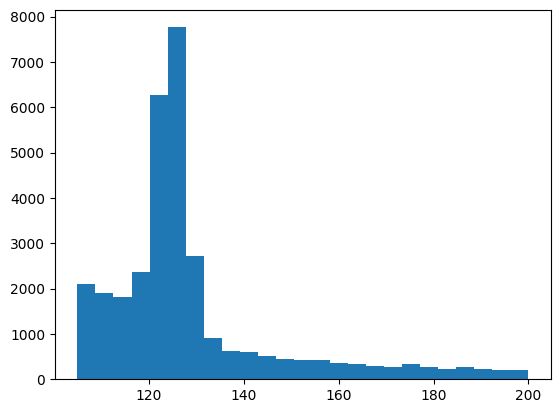

Adversary MSE on test set: 0.8110


In [74]:
adversary_model.eval()
with torch.no_grad():
    test_logits, test_hidden_rep = classifier_model(X_test_tensor.to(device))
    test_predictions = torch.sigmoid(test_logits)
    # Calculate accuracy, AUC for classifier

    if DEBIAS_TRAINING:
        mass_predictions_adv_test = adversary_model(test_hidden_rep)
        unscaled_mass_test = mass_scaler.inverse_transform(
            mass_test_tensor.cpu().numpy().reshape(-1, 1)
        ).flatten()
        unscaled_mass_test = unscaled_mass_test[unscaled_mass_test < 200]
        plt.hist(unscaled_mass_test, bins=25)
        plt.show()
        # Calculate MSE for adversary on test set
        test_adv_loss = criterion_adv(mass_predictions_adv_test, mass_test_tensor.to(device))
        print(f"Adversary MSE on test set: {test_adv_loss.item():.4f}")